In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS
import kvn


from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

21584
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
for i in range(100):
    plt.close()

In [3]:
# -----------------------------------------------------------------------
# --- Periodic boundary conditions ---
# -----------------------------------------------------------------------
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
# matplotlib.rc('axes', linewidth=2)
# matplotlib.rc('font', weight='bold')

def der_first(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - y[ii-1]
        else:
            y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der
# -----------------------------------------------------------------------
def der_second(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - 2. * y[ii] + y[ii - 1]
        else:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[ii - 1]
    y_der /= (dx**2)
    return y_der
# -----------------------------------------------------------------------
def plot_tx(x, t, y, flag_simple=True):
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    cmap_two_signs_= 'coolwarm'
    if flag_simple:
        fontsize = 16

        XX, YY = np.meshgrid(t, x)
        fig_tx = plt.figure(figsize=(8, 6))
        ax = fig_tx.add_subplot(111)
        cs = ax.contourf(
            XX, YY, np.transpose(y), 
            levels=100, cmap=cmap_two_signs_, norm=divnorm
        )
        cb = fig_tx.colorbar(cs, ax = ax)
        cb.ax.ticklabel_format(style="scientific")
        cb.ax.tick_params(labelsize=fontsize) 
        ax.set_xlabel('$t$', fontsize = fontsize)
        ax.set_ylabel('$x$', fontsize = fontsize)
        ax.set_title('$y(t,x)$', fontsize = fontsize)
        ax.set_xlim(0, np.max(t))
        ax.set_ylim(0, np.max(x))
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
    else:
        fontsize = 30
        coef_labels = 1.2

        XX, YY = np.meshgrid(t, x)
        fig_tx = plt.figure(figsize=(14, 10))
        ax = fig_tx.add_subplot(111)
        cs = ax.contourf(
            XX, YY, np.transpose(y), 
            levels=100, cmap=cmap_two_signs_, norm=divnorm
        )
        cb = fig_tx.colorbar(cs, ax = ax)
        cb.ax.ticklabel_format(style="scientific")
        cb.ax.tick_params(labelsize=fontsize) 
        ax.set_xlabel('$t$', fontsize = coef_labels*fontsize)
        ax.set_ylabel('$s$', fontsize = coef_labels*fontsize)
        ax.set_title('$\psi(t,s)$', fontsize = coef_labels*fontsize)
        ax.set_xlim(0, np.max(t))
        ax.set_ylim(0, np.max(x))
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
    return

v	 1.0
D	 1.0e-02
Nx	 64
Nt	 16384

--- Stability criteria ---
current dx, dt:	 1.587e-02, 1.465e-04
maximum dx, dt:	 2.000e-02, 1.260e-02
Courant number: 0.00923

spectral norm.: 1.588e+02


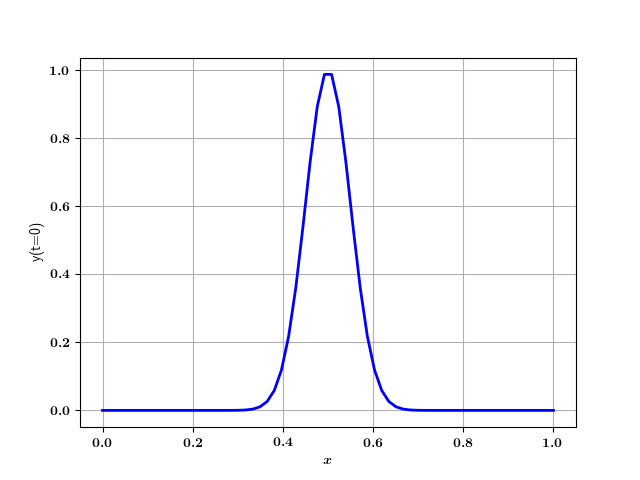

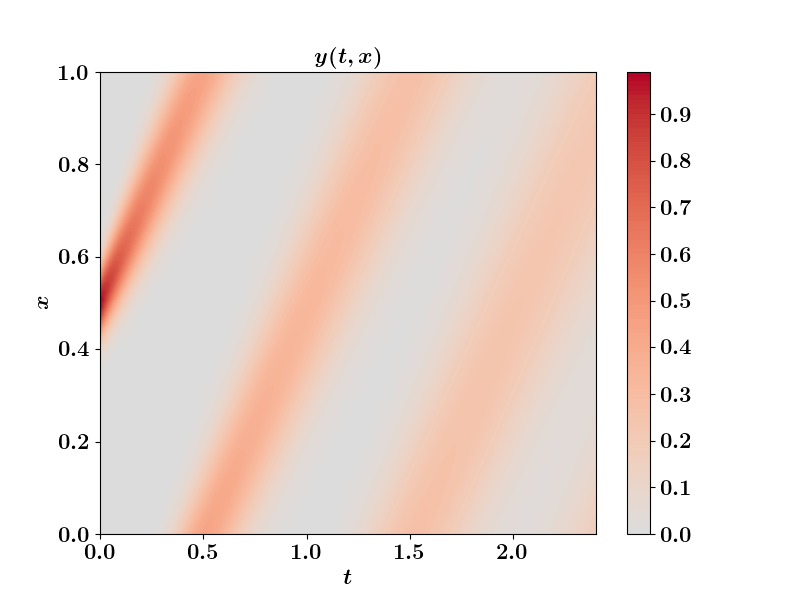

In [27]:
# ---------------------------------------------------------------------
# --- Diffusion-Advection equation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(LCHS)

nx_, nt_ = 6, 14
xmax_ = 1.0
v_ = 1.0
D_ = 0.01

# tmax_ = 0.8
tmax_ = 2.4

# --- Grids ---
Nx_ = 1 << nx_
Nt_ = 1 << nt_
x_ = np.linspace(0, xmax_, Nx_)
t_ = np.linspace(0, tmax_, Nt_)
dt = np.diff(t_)[0]
dx_ = np.diff(x_)[0]

print("v\t {:0.1f}".format(v_))
print("D\t {:0.1e}".format(D_))
print("Nx\t {:d}".format(Nx_))
print("Nt\t {:d}".format(Nt_))

print("\n--- Stability criteria ---")
dx_max = 2. * D_ / v_
dt_max = dx_**2 / (2. * D_)
print("current dx, dt:\t {:0.3e}, {:0.3e}".format(dx_, dt))
print("maximum dx, dt:\t {:0.3e}, {:0.3e}".format(dx_max, dt_max))
print("Courant number: {:0.3}".format(v_ * dt/ dx_))
print()

# ---------------------------------------------------------------------
# --- ADE matrix ---
# ---------------------------------------------------------------------
def get_A_DC():
    A = np.zeros((Nx_, Nx_))
    beta = 1. / (dx_**2)
    sigma = 1. / (2.*dx_)
    coef_r = D_ * beta - v_ * sigma
    coef_c = -2. * D_ * beta
    coef_l = D_ * beta + v_ * sigma
    for ir in range(Nx_):
        ic_l = ir - 1
        ic_r = ir + 1
        if ir == 0:
            ic_l = Nx_ - 1
        if ir == (Nx_ - 1):
            ic_r = 0

        A[ir, ic_l] = coef_l
        A[ir, ir]   = coef_c
        A[ir, ic_r] = coef_r

    sp_norm = np.linalg.norm(A, ord=2)
    print("spectral norm.: {:0.3e}".format(sp_norm))
    return -A
# -------------------------------------------------------------
A_ = get_A_DC()

# ---------------------------------------------------------------------
# --- Initial condition ---
# ---------------------------------------------------------------------
def init_cond():
    y_init = np.exp( - (x_ - xc_init_)**2/(2. * width_init_**2))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_init, color='blue', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.ylabel("y(t=0)")
    plt.grid(True)
    plt.show()
    return y_init
# -------------------------------------------------------------
xc_init_ = xmax_/2.
width_init_ = 0.05
psi_init_ = init_cond()

# ---------------------------------------------------------------------
# --- Reference classical simulation ---
# ---------------------------------------------------------------------
def ref_CL(flag_RG = True):
    # --- chosen derivative method ---
    def func_RHS(yx_new):
        dx_y  = der_first(yx_new, dx_)
        d2x_y = der_second(yx_new, dx_) 
        RK = - v_ * dx_y + D_ * d2x_y
        return RK
    # -----------------------------------------
    y = np.zeros((Nt_, Nx_))
    y[0,:] = np.array(psi_init_)

    # --- first-order der. in time ---
    if not flag_RG:
        for it in range(Nt_-1):
            t1 = t_[it]
            yx = y[it,:]
            y[it+1,:] = yx + dt * func_RHS(yx)
    # --- 4-th order Runge-Kutta ---
    else:
        dt2 = dt/2.
        dt6 = dt/6.
        for it in range(Nt_-1):
            t1 = t_[it]
            yx = y[it,:]

            # --- Step 1 ---
            RK_k1 = func_RHS(yx)

            # --- Step 2 ---
            yx_new = yx + dt2 * RK_k1
            RK_k2 = func_RHS(yx_new)

            # --- Step 3 ---
            yx_new = yx + dt2 * RK_k2
            RK_k3 = func_RHS(yx_new)

            # --- Step 4 ---
            yx_new = yx + dt * RK_k3
            RK_k4 = func_RHS(yx_new)

            # --- Next time point ---
            y[it+1,:] = y[it,:] + dt6 * (RK_k1 + 2.*RK_k2 + 2.*RK_k3 + RK_k4)
    return y
# --------------------------------------------------------------
y_ref_ = ref_CL(flag_RG = True)
plot_tx(x_, t_, y_ref_, flag_simple=True)

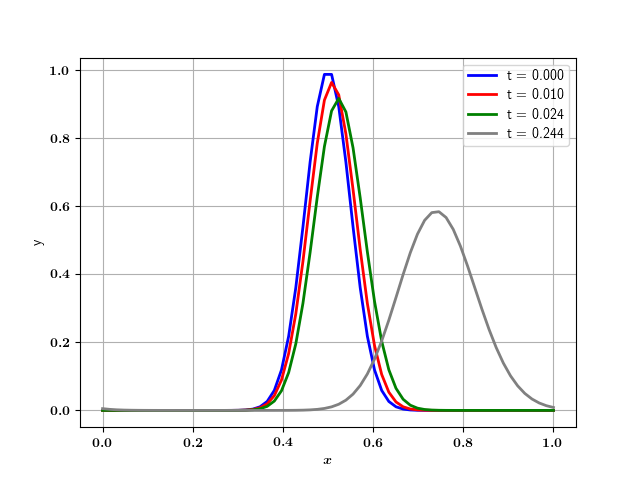

In [32]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
def plot_diff_time_moments(t_moments):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for it in range(len(t_moments)):
        id_t = t_moments[it]
        ax.plot(
            x_, y_ref_[id_t, :], 
            color=colors_[it], linewidth = 2, linestyle='-',  
            label = "t = {:0.3f}".format(t_[id_t])
        )
    plt.xlabel('$x$')
    plt.ylabel("y")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# ------------------------------------------------------------------
plot_diff_time_moments(t_moments = [0, 40, 100, 1000])

In [28]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
mix.reload_module(LCHS)
def computation_LCHS_py(t_LCHS, k_max_py, Nk, beta):
    k_grid = np.linspace(-k_max_py, k_max_py, Nk)
    dk = np.diff(k_grid)[0]
    print("Nk, dk, kmax: {:d}, {:0.3e}, {:0.3f}".format(Nk, dk, k_max_py))

    # psi_LCHS_py = kvn.LCHS_computation(
    #     k_grid, t_LCHS,
    #     A_, psi_init_, Nt_steps = 1, 
    #     flag_trotterization = False, 
    #     flag_print = False
    # )
    psi_LCHS_py = kvn.LCHS_computation_OPT(
        k_grid, t_LCHS, beta, A_, psi_init_
    )
    print("Done.")

    # --- Form a string to save data ---
    str_save_t = "t{:d}".format(int(10 * t_LCHS))
    str_save_pyLCHS = "kmax{:d}_dk{:d}".format(int(k_max_py), int(1000*dk))
    return psi_LCHS_py, str_save_t, str_save_pyLCHS
# ------------------------------------------------------------------------
beta_py = 0.700

# k_max_py, Nk_py = 120., 1<<13
# k_max_py, Nk_py = 80., 1<<11
# k_max_py, Nk_py = 40., 1<<11
# k_max_py, Nk_py = 20., 1<<11


k_max_py, Nk_py = 40., 1<<12


# --- Perform the LCHS simulations ---
print("beta: {:0.3f}".format(beta_py))
psi_LCHS_py_, str_save_t_, str_save_pyLCHS_ = computation_LCHS_py(tmax_, k_max_py, Nk_py, beta_py)

# --- interpolate reference simulations ---
y_interp = np.array(y_ref_[-1,:])
# psi_LCHS_py_ *= np.max(np.abs(y_interp)) / np.max(np.abs(psi_LCHS_py_))

# --- maximum error ---
max_abs_err = np.max(np.abs(y_interp - psi_LCHS_py_))
print("max. abs. error, log: {:0.3e}, {:0.3e}".format(max_abs_err, np.log10(max_abs_err)))
print("norm. error: {:0.3e}".format(max_abs_err/np.max(y_interp)))
del beta_py, k_max_py, Nk_py

beta: 0.700
Nk, dk, kmax: 4096, 1.954e-02, 40.000
Done.
max. abs. error, log: 1.569e-05, -4.804e+00
norm. error: 7.048e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Computation status:  9.004096109904856e-06

c[0] = 1.188e-01


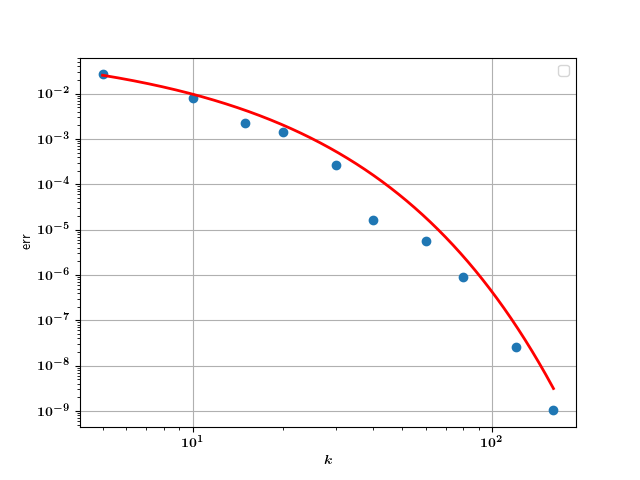

write data to a file: ./jupyter-notebooks/NL/results//scan_approx_err_kmax_PY.dat


In [53]:
# ----------------------------------------------------
# --- Scans ---
# ----------------------------------------------------
def scan_err_kmax():
    def save_one(tmax, beta, dk, x, y, flag_std = False):
        str_t = "t{:0.1f}".format(tmax)
        str_beta = "b{:0.2f}".format(beta)
        str_dk = "dk{:0.3e}".format(dk)

        x = np.array(x)
        y = np.array(y)
        if not flag_std:
            mix.save_dat_plot_1d_file(
                path_save_ + "/scan_ERR_KMAX_{:s}_{:s}_{:s}_PY.dat".format(str_t, str_beta, str_dk), 
                np.array(x), y
            )
        else:
            mix.save_dat_plot_1d_file(
                path_save_ + "/scan_ERR_KMAX_{:s}_{:s}_PY_STD.dat".format(str_t, str_dk), 
                np.array(x), y
            )
        return
    # ------------------------------------------------------------------
    tmax = 0.8 
    beta = 0.700
    
    # ---
    dk = 2.9e-02
    kmax_array = [      15.,       30.,       60.,      120.]
    err_array  = [7.256e-03, 2.957e-03, 1.401e-03, 6.789e-04]
    save_one(tmax, beta, dk, kmax_array, err_array, flag_std = True)

    dk = 3.9e-02
    kmax_array = [       5.,       10.,       20.,       40.,        80.,       160.]
    err_array  = [2.774e-02, 1.083e-02, 4.679e-03, 2.168e-03,  1.043e-03,  5.086e-04]
    save_one(tmax, beta, dk, kmax_array, err_array, flag_std = True)

    dk = 2.9e-02
    kmax_array = [      15.,       30.,       60.,      120.]
    err_array  = [2.304e-03, 2.730e-04, 5.620e-06, 2.562e-08]
    save_one(tmax, beta, dk, kmax_array, err_array, flag_std = False)

    dk = 3.9e-02
    kmax_array = [       5.,       10.,       20.,       40.,        80.,       160.]
    err_array  = [2.651e-02, 7.832e-03, 1.394e-03, 1.617e-05,  9.010e-07,  1.030e-09]
    save_one(tmax, beta, dk, kmax_array, err_array, flag_std = False)
    return
# ----------------------------------------------------
def scan_err_beta():
    def save_one(tmax, kmax, dk, x, y):
        str_t = "t{:0.1f}".format(tmax)
        str_kmax = "kmax{:d}".format(int(kmax))
        str_dk = "dk{:0.3e}".format(dk)

        x = np.array(x)
        y = np.array(y)
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_ERR_BETA_{:s}_{:s}_{:s}_PY.dat".format(str_t, str_kmax, str_dk), 
            np.array(x), y
        )
        return
    # ------------------------------------------------------------------
    tmax = 0.8 
    dk = 3.9e-02
    
    
    # ---
    kmax = 10
    beta_array = [    0.100,     0.200,     0.300,     
                      0.400,     0.440,     0.480,     
                      0.500,     0.540,     0.540,     0.600,     
                      0.700,     0.720,     0.740,     0.760,     0.780,     0.800,     0.900]
    err_array  = [7.738e-02, 5.947e-02, 3.987e-02, 
                  1.963e-02, 1.186e-02, 4.646e-03, 
                  3.105e-03, 4.439e-03, 8.636e-03, 1.002e-02, 
                  7.832e-03, 5.490e-03, 2.623e-03, 1.441e-03, 4.154e-03, 7.333e-03, 6.293e-03]
    save_one(tmax, kmax, dk, beta_array, err_array)

    # ---
    kmax = 40
    beta_array = [    0.100,     0.200,     0.300,             
                      0.400,     0.500,     0.600,     0.620,     0.640,     0.660,     0.680,
                      0.700,     0.720,     0.740,     0.760,     0.780,     0.800,     0.900]
    err_array  = [4.701e-02, 2.597e-02, 8.891e-03,   
                  4.091e-04, 6.633e-04, 2.070e-04, 8.357e-05, 5.157e-05, 1.068e-04, 8.069e-05,
                  1.617e-05, 6.450e-05, 4.699e-05, 3.144e-05, 5.598e-05, 2.155e-05, 5.786e-05]
    save_one(tmax, kmax, dk, beta_array, err_array)

    # ---
    kmax = 80
    beta_array = [    0.100,     0.200,     0.300,             
                      0.400,     0.500,     0.600,     
                      0.700,     0.720,     0.740,     0.760,     0.780,     0.800,     0.900]
    err_array  = [3.974e-02, 1.754e-02, 3.393e-03, 
                  4.402e-04, 4.886e-05, 4.961e-06, 
                  9.010e-07, 1.894e-07, 4.638e-07, 4.595e-07, 3.657e-07, 3.216e-07, 1.843e-06]
    save_one(tmax, kmax, dk, beta_array, err_array)
    return
# ----------------------------------------------------
def approx_scan_err_kmax(flag_save):
    def test_func(x, c):
        # res_pol = c[0]
        # for ic in range(1, Nc):
        #     res_pol += c[ic] * np.exp(-0.5 * x**beta * np.cos(beta * np.pi/2.))
        res_pol = 0
        for ic in range(Nc):
            # res_pol += c[ic] * np.exp(-0.5 * x**beta * np.cos(beta * np.pi/2.))
            res_pol += c[ic] * np.exp(-0.5 * x**beta)
        return res_pol
    
    def test_func_np(x, c):
        Nx = np.size(x)
        y = np.zeros(Nx)
        for ix in range(Nx):
            # y[ix] = c[0]
            # for ic in range(1, Nc):
            #     y[ix] += c[ic] * np.exp(-0.5 * x[ix]**beta)
            y[ix] = 0
            for ic in range(Nc):
                y[ix] += c[ic] * np.exp(-0.5 * x[ix]**beta)
        return y
    # ----------------------------------------------------

    kmax_array = np.array([       5.,       10.,       15.,       20.,       30.,       
                        40.,       60.,       80.,      120.,      160.])
    err_array  = np.array([2.651e-02, 7.832e-03, 2.304e-03, 1.394e-03, 2.730e-04, 
                  1.617e-05, 5.620e-06, 9.010e-07, 2.562e-08, 1.030e-09])
    
    # kmax_array = np.array([       5.,       10.,       20.,       40.,        80.,       160.])
    # err_array  = np.array([2.651e-02, 7.832e-03, 1.394e-03, 1.617e-05,  9.010e-07,  1.030e-09])
    
    # --- minimization ---
    beta = 0.700
    Nc = 1
    coefs = cp.Variable(Nc)
    objective = cp.Minimize(cp.sum_squares(
        test_func(kmax_array, coefs) - err_array
    ))
    prob = cp.Problem(objective)
    result = prob.solve()
    print("Computation status: ", result)
    print()

    for ic in range(Nc):
        print("c[{:d}] = {:0.3e}".format(ic, coefs.value[ic]))

    k_grid_fine = np.linspace(kmax_array[0], kmax_array[-1], 10000)
    y_approx = test_func_np(k_grid_fine, coefs.value)

    # --- plotting ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.loglog(kmax_array, err_array,  "o",  linewidth = 2)
    ax.loglog(k_grid_fine, y_approx, "-r",  linewidth = 2)
    plt.xlabel('$k$')
    plt.ylabel("err")
    ax.legend()
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
                path_save_ + "/scan_approx_err_kmax_PY.dat", 
                k_grid_fine, y_approx
            )
    return
# ----------------------------------------------------
# scan_err_kmax()
# scan_err_beta()
approx_scan_err_kmax(flag_save = True)

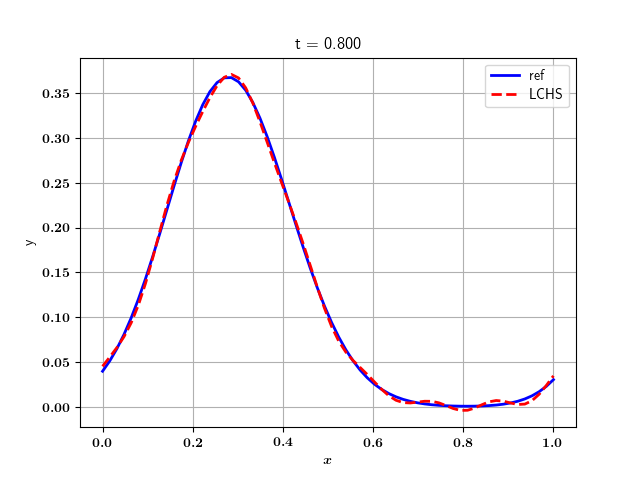

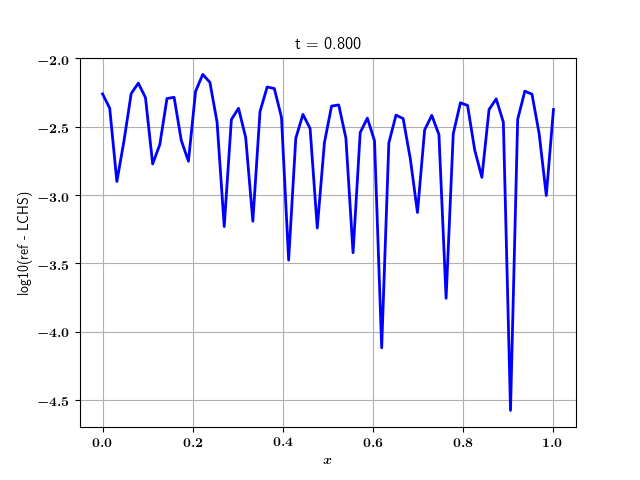

In [89]:
# --------------------------------------------------
# --- Compare reference and LCHS-py simulations  ---
# --------------------------------------------------
mix.reload_module(mix)
def compare_CL_LCHS_PY(flag_save):
    # --- Plotting signals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.plot(x_, y_ref_[0,:],     "black",  linewidth = 2, label = "init")
    ax.plot(x_, y_interp,           "-b",  linewidth = 2, label = "ref")
    ax.plot(x_, psi_LCHS_py_.real, "--r", linewidth = 2, label = "LCHS")
    plt.xlabel('$x$')
    plt.ylabel("y")
    plt.title("t = {:0.3f}".format(tmax_))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting errors ---
    abs_err = y_interp - psi_LCHS_py_.real

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, np.log10(np.abs(abs_err)), "-b",  linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("log10(ref - LCHS)")
    plt.title("t = {:0.3f}".format(tmax_))
    plt.grid(True)
    plt.show()

    # # --- Plotting relative errors ---
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(x_, np.abs(y_interp - psi_LCHS_py_)/np.abs(y_interp), "-b",  linewidth = 2)
    # plt.xlabel('$x$')
    # plt.ylabel("re. error")
    # plt.title("t = {:0.3f}".format(tmax_))
    # plt.grid(True)
    # plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_CL_{:s}.dat".format(str_save_t_), 
            x_, y_interp
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_PY_LCHS_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x_, psi_LCHS_py_.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/CDE_PY_LCHS_ERR_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x_, np.log10(np.abs(abs_err))
        )
    return
# -------------------------------------------------------------------
compare_CL_LCHS_PY(flag_save = False)

In [29]:
# -------------------------------------------------------------------------
# --- Initial parameters for the BE in the QuCF LCHS simulations ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(LCHS)

# ------------------------------------------------------------
# QSP can give a minus sign           -> affects both AH and Bm
# AA of weights can give a minus sign -> affects only Bm
# ------------------------------------------------------------

coef_lcu_ = 2.
beta_ = 0.700 
sign_w = -1 # !!! to correct the weights global phase (should be 1 for some combinations of nk and kmax) !!!
sign_qsp = -1 # !!! to correct the QSP global phase !!!

flag_scan_t_ = True

if beta_ == 0.700:
    # k_max_, nk_, rr_w_ = 10.0,   5,  4.987032727149e+00
    # k_max_, nk_, rr_w_ = 10.0,   7,  1.009392172023e+01
    # k_max_, nk_, rr_w_ = 10.0,   9,  2.024974348049e+01
    # k_max_, nk_, rr_w_ = 20.0,   8,  1.401957690537e+01
    # k_max_, nk_, rr_w_ = 160.0, 11,  3.959684676225e+01
    # k_max_, nk_, rr_w_ = 100.0,  9,  1.980775248126e+01

    # k_max_, nk_, rr_w_        = 20.0,    7,  9.924418770964e+00
    # k_max_, nk_, rr_w_, sign_ = 20.0,    8,  1.401957690537e+01,   1
    # k_max_, nk_, rr_w_        = 20.0,    9,  1.988276644586e+01
    # k_max_, nk_, rr_w_        = 20.0,   10,  2.809620086613e+01
    # k_max_, nk_, rr_w_, sign_ = 20.0,   11,  3.974114634266e+01,   1
    # k_max_, nk_, rr_w_        = 20.0,   12,  5.622450849037e+01

    # k_max_, nk_, rr_w_ = 40.0,   7,  9.896357602441e+00
    # k_max_, nk_, rr_w_ = 40.0,   8,  1.397503280957e+01
    # k_max_, nk_, rr_w_ = 40.0,   9,  1.981270195959e+01
    # k_max_, nk_, rr_w_ = 40.0,   10,  2.800181982885e+01
    # k_max_, nk_, rr_w_ = 40.0,   11,  3.960666927518e+01
    k_max_, nk_, rr_w_ = 40.0,   12,  5.603030858981e+01

    # k_max_, nk_, rr_w_ = 80.0,  7,  1.003005883646e+01
    # k_max_, nk_, rr_w_ = 80.0,  8,  1.397761275106e+01
    # k_max_, nk_, rr_w_ = 80.0,  9,  1.980767542286e+01
    # k_max_, nk_, rr_w_ = 80.0,  10,  2.799503405685e+01
    # k_max_, nk_, rr_w_ = 80.0,  11,  3.959700078398e+01
    # k_max_, nk_, rr_w_ = 80.0,  12,  5.601634647580e+01
    # k_max_, nk_, rr_w_ = 80.0,  13,  7.921835590877e+01


Nk_ = 1 << nk_
name_beta_ = "b{:0.1f}".format(beta_)

# --- LCHS matrices ---
AL_, AH_ = mix.get_herm_aherm_parts(sign_qsp * A_)
Bm_ = k_max_ * AL_
C_ = AH_ + Bm_
_, norm_of_C, _ = mix.compute_normalized_matrix(C_, "C", True)

norm_of_C *= 4. / 3. # correction because the nonsparsity is 3 but 1/max(D) is 4

BE_norm_ = coef_lcu_ * norm_of_C # double because of LCU
print("BE-norm: {:0.3e}".format(BE_norm_))
print()
del norm_of_C

# --- normalized matrices for the BE ---
AH_norm_ = AH_ / BE_norm_
Bm_norm_ = sign_w * Bm_ / BE_norm_
_, _, nonsparsity_AH = mix.compute_normalized_matrix(AH_norm_, "AH_norm_", True)
_, _, nonsparsity_Bm = mix.compute_normalized_matrix(Bm_norm_, "Bm_norm_", True)

# --- Path with the QuCF simulation ---
path_root_ = "../QuCF/simulations/LCHS/ADE-OPT/"
name_pr_ = ""

if not flag_scan_t_:
    name_t_ = None
    if tmax_ == 0.8:  
        name_t_ = "t08"
    if tmax_ == 1.0:  
        name_t_ = "t10"
    if tmax_ == 2.0:  
        name_t_ = "t20"
    name_kmax_ = "nk{:d}_kmax{:d}".format(nk_, int(k_max_))

    name_pr_ += name_t_ + "/"
    name_pr_ += name_kmax_
    name_pr_ += "-OPT"
else:
    name_t_ = "t{:0.1f}".format(tmax_)
    name_kmax_ = "kmax{:d}".format(int(k_max_))
    name_pr_ = "/scan_t_{:s}/{:s}".format(name_kmax_, name_t_)
    # !!! Choose correctly nk for each t !!!


path_qucf_ = path_root_ + "{:s}".format(name_pr_)

# --- Print parameters ---
print("\n--- Chosen parameters for the LCHS-QuCF simulation ---")
print("kmax, nk, beta:\t {:0.3f}, {:d}, {:0.2f}".format(k_max_, nk_, beta_))
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))

Matrix C:	 nonsparsity, coefnorm: 3, 1.167e+04
BE-norm: 3.111e+04

Matrix AH_norm_:	 nonsparsity, coefnorm: 2, 2.864e-03
Matrix Bm_norm_:	 nonsparsity, coefnorm: 3, 3.750e-01

--- Chosen parameters for the LCHS-QuCF simulation ---
kmax, nk, beta:	 40.000, 12, 0.70
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/ADE-OPT//scan_t_kmax40/t2.4


In [7]:
# ------------------------------------------------------------
# --- Parameters for the BE ---
# !!! when kmax is changed, then t_qsp is changed as well --> QSP angles must be recalculated !!!
# ------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def print_values(name_B, B, ir = 1):
    ic_l = ir - 1
    ic_r = ir + 1
    if ir == 0:
        ic_l = Nx_ - 1
    if ir == Nx_ - 1:
        ic_r = 0
    vl, vc, vr = B[ir, ic_l], B[ir, ir], B[ir, ic_r]
    print("{:s}: vl, vc, vr:\t {:20.3e}, {:20.3e}, {:20.3e}".format(name_B, vl, vc, vr))
    return
# -------------------------------------------------------------------------------
def compute_angles(name_B, B, d_vals, ir, flag_c):
    print("\n\t// --- BE: {:s} ---".format(name_B))
    ay_l, az_l = mix.calc_angles_from_a_value(B[ir, ir-1] / d_vals[0])
    ay_c, az_c = mix.calc_angles_from_a_value(B[ir, ir]   / d_vals[1])
    ay_r, az_r = mix.calc_angles_from_a_value(B[ir, ir+1] / d_vals[2])
    print("\tay_{:s}_l  {:0.12e}".format(name_B, ay_l))
    if az_l is not None:
        print("\taz_{:s}_l  {:0.12e}".format(name_B, az_l))

    if flag_c:
        print("\tay_{:s}_c  {:0.12e}".format(name_B, ay_c))
        if az_c is not None:
            print("\taz_{:s}_c  {:0.12e}".format(name_B, az_c))

    print("\tay_{:s}_r  {:0.12e}".format(name_B, ay_r))
    if az_r is not None:
        print("\taz_{:s}_r  {:0.12e}".format(name_B, az_r))
    return
# -------------------------------------------------------------------------------
def compute_BE_parameters():
    # --- Compute angles for the OH ---
    ir_ch = 1
    print_values("AH_norm", coef_lcu_ * AH_norm_, ir_ch)
    print_values("Bm_norm", coef_lcu_ * Bm_norm_, ir_ch)

    print("\n\t// --- Spatial resolution ---")
    print("\tnx {:d}".format(nx_))

    compute_angles("AH", coef_lcu_ * AH_norm_, [0.50, 0.50, 0.50], ir_ch, False)
    compute_angles("Bm", coef_lcu_ * Bm_norm_, [0.25, 0.25, 0.50], ir_ch, True)

    # # mix.plot_structure_simple(Ba_norm, marker_size = 30)
    # # mix.plot_structure_simple(B_kmax_norm, marker_size = 30)
    # # kvn.plot_save_diagonals(Ba_norm, "Ah-norm", False, False, "")
    # # kvn.plot_save_diagonals(B_kmax_norm, "Ah-norm", False, False, "")

    # --- Compute angles for the weights ---
    alpha_k0_pih = - np.pi/2.
    alpha_k1_pih = np.abs(alpha_k0_pih) * Nk_/(Nk_ - 1)

    print("\n\t//--- LCHS Fourier grid ---")
    print("\tkmax \t{:0.3f}".format(k_max_))
    print("\tnk \t\t{:d}".format(nk_))
    print("\tbeta \t{:0.3f}".format(beta_))
    print("\talpha_k0_pih \t{:0.12e}".format(alpha_k0_pih))
    print("\talpha_k1_pih \t{:0.12e}".format(alpha_k1_pih))

    # --- Initialization --- 
    print("\n\t//--- Initialization ---")

    # alpha_init_0 = -0.5
    # alpha_init_1 = 0.5 * Nx_/(Nx_ - 1)
    # print("\talpha_init_0 \t{:0.12e}".format(alpha_init_0))
    # print("\talpha_init_1 \t{:0.12e}".format(alpha_init_1))

    print("\txc_init \t{:0.3e}".format(xc_init_))
    print("\twd_init \t{:0.3e}".format(width_init_))

    # --- Normalized time interval ---
    print("----------------------------------------------------")
    print("\n--- time moments (not for the BE)---")
    t_qsp = BE_norm_ * tmax_
    print("t = {:0.12e}".format(t_qsp))
    return
# -------------------------------------------------------------------------------
compute_BE_parameters()

AH_norm: vl, vc, vr:	 0.000e+00-4.049e-03j, 0.000e+00+0.000e+00j, 0.000e+00+4.049e-03j
Bm_norm: vl, vc, vr:	           -1.020e-01,            2.041e-01,           -1.020e-01

	// --- Spatial resolution ---
	nx 6

	// --- BE: AH ---
	ay_AH_l  3.125396397693e+00
	az_AH_l  3.141592653590e+00
	ay_AH_r  3.125396397693e+00
	az_AH_r  -3.141592653590e+00

	// --- BE: Bm ---
	ay_Bm_l  3.982426679679e+00
	ay_Bm_c  1.231701253247e+00
	ay_Bm_r  3.552621110114e+00

	//--- LCHS Fourier grid ---
	kmax 	20.000
	nk 		10
	beta 	0.700
	alpha_k0_pih 	-1.570796326795e+00
	alpha_k1_pih 	1.572331807075e+00

	//--- Initialization ---
	xc_init 	5.000e-01
	wd_init 	5.000e-02
----------------------------------------------------

--- time moments (not for the BE)---
t = 2.489491457582e+04



Reading the file ../QuCF/simulations/LCHS/ADE-OPT//scan_t_kmax40/t2.4/dc_OUTPUT.hdf5...
Name of the simulation is dc
Simulation has been performed  10-02-2024 23:13:30
A-max: 7.199936056435e-02
success prob: 1.316e-01
N-gates: 17925174
max-err, log: 1.569e-05, -4.804e+00


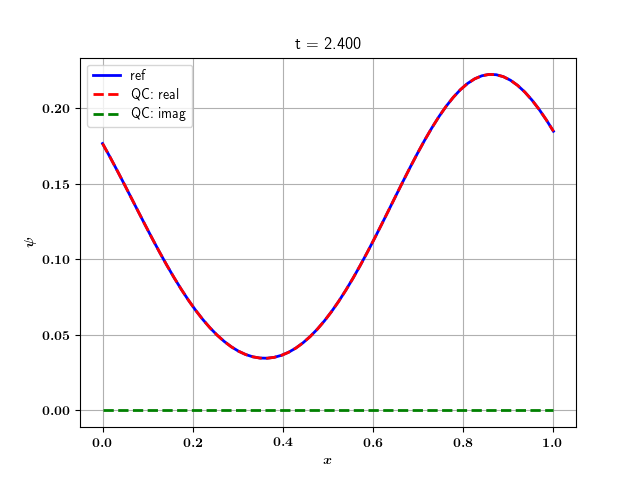

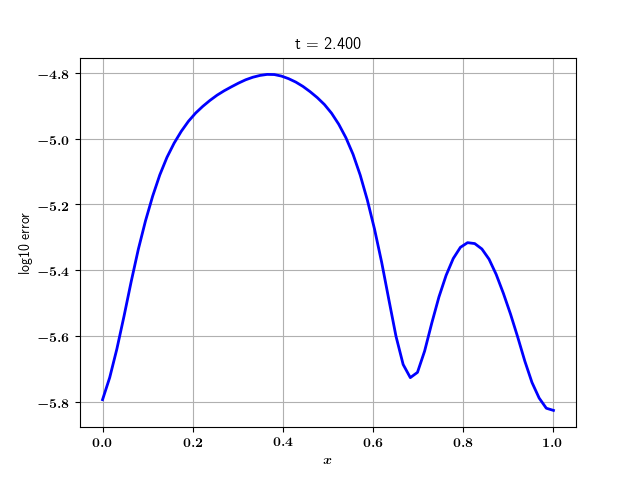


max-err/max-v: 7.048e-05


In [ ]:
# --------------------------------------------------------
# --- Compare results with quantum simulations ---
# --------------------------------------------------------
def read_qc_data(path_qc, flag_init):
    print()  

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qc
    om.pname_ = "dc"
    om.open()
    
    # --- get the result ---
    Ngates = om.dd_["N-gates"]
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    
    print("A-max: {:0.12e}".format(np.max(np.abs(qc_state))))
    print("success prob: {:0.3e}".format(  np.sum(np.abs(qc_state)**2)  ))
    print("N-gates: {:d}".format(Ngates))

    # --- renormalization due to the initialization ---
    qc_state *= 2**(nx_/2.)
    if int(nx_) == 6 and width_init_ == 0.05:
        # rr_init = 3.379733933513e+00 # for QSVT initialization
        rr_init = 3.377008135457e+00  # for Dir initialization
    qc_state /= rr_init

    # renormalization due to the influence of the weights:
    # the coefficients rr_w are computed in calc-weights_OPT.ipynb
    if not flag_init:
        om.read_qsvt()
        Hadamart_norm_factor = 2**(nk_) 
        qc_state *= Hadamart_norm_factor    
        qc_state /= rr_w_**2

    return qc_state
# ------------------------------------------------------------------------------
def compare_ref_qu(flag_init, flag_save_cl, flag_save_qu, flag_save_err, flag_plot):
    sign_qucf = 1.0
    if flag_init:
        sign_qucf = 1.0
        y_ref_ch = np.array(psi_init_)
    else:
        y_ref_ch = np.array(y_ref_[-1,:])
    psi_qc = sign_qucf * read_qc_data(path_qucf_, flag_init)

    # psi_qc = psi_qc[::-1]
    # psi_qc /= np.max(np.abs(psi_qc))
    # y_ref_ch /= np.max(np.abs(y_ref_ch))
    # psi_qc *= np.max(np.abs(y_ref_ch)) / np.max(np.abs(psi_qc))

    # --- Compute the absolute error ---
    err_res = np.abs(y_ref_ch - psi_qc.real)
    max_abs_err = np.max(np.abs(err_res))
    print("max-err, log: {:0.3e}, {:0.3e}".format(
        max_abs_err, np.log10(max_abs_err))
    )

    # --- Compare the quantum state and the reference simulation ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_, y_ref_ch,    "-b",  linewidth = 2, label = "ref")
        ax.plot(x_, psi_qc.real, "--r", linewidth = 2, label = "QC: real")
        ax.plot(x_, psi_qc.imag, "--g", linewidth = 2, label = "QC: imag")
        plt.xlabel('$x$')
        plt.ylabel("$\psi$")
        ax.legend()
        plt.title("t = {:0.3f}".format(tmax_))
        plt.grid(True)
        plt.show()

        # --- Absolute error ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_, np.log10(err_res), "-b", linewidth = 2)
        plt.xlabel('$x$')
        plt.ylabel("log10 error")
        plt.title("t = {:0.3f}".format(tmax_))
        plt.grid(True)
        plt.show()

    print()
    print("max-err/max-v: {:0.3e}".format(max_abs_err/np.max(y_ref_ch)))

    if flag_save_cl:
        mix.save_dat_plot_1d_file(
            path_save_ + "/ADE_CL_{:s}.dat".format(name_t_), 
            x_, y_ref_ch
        )

    if flag_save_qu:
        mix.save_dat_plot_1d_file(
            path_save_ + "/ADE_QuCF_{:s}_{:s}_{:s}.dat".format(name_t_, name_kmax_, name_beta_),  
            x_, psi_qc.real
        )

    if flag_save_err:
        mix.save_dat_plot_1d_file(
            path_save_ + "/ADE_QuCF_err_{:s}_{:s}_{:s}.dat".format(name_t_, name_kmax_, name_beta_), 
            x_, err_res
        )
    return
# ------------------------------------------------------------------------------
compare_ref_qu(
    flag_init = False, # whether only the initialization circuit was simulated
    flag_save_cl  = False,
    flag_save_qu  = False,
    flag_save_err = False,
    flag_plot = True
)

In [31]:
# ----------------------------------------------------
# --- Scans ---
# ----------------------------------------------------
def scan_err_nk_qucf():
    def save_one(tmax, beta, kmax, x, y, str_v):
        str_t = "t{:0.1f}".format(tmax)
        str_beta = "b{:0.2f}".format(beta)
        str_kmax = "kmax{:0.3e}".format(kmax)

        x = np.array(x)
        y = np.array(y)
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_{:s}_NK_{:s}_{:s}_{:s}_QuCF.dat".format(str_v, str_t, str_beta, str_kmax), 
            x, y
        )
        return
    # ------------------------------------------------------------------
    tmax = 0.8 
    beta = 0.700

    # ---
    kmax = 20.
    nk_array        = [        7,         8,         9,        10,        11]
    norm_err_array  = [2.026e-02, 4.104e-03, 3.959e-03, 3.928e-03, 3.928e-03]
    Ng_array        = [  2692135,   2752429,   2826923,   2936837,   3152439]
    succ_prob_array = [2.151e-01, 2.140e-01, 2.165e-01, 2.158e-01, 2.159e-01]
    save_one(tmax, beta, kmax, nk_array, norm_err_array, "ERR")
    save_one(tmax, beta, kmax, nk_array, Ng_array, "Ng")
    save_one(tmax, beta, kmax, nk_array, succ_prob_array, "SUCC_PROB")
    
    # ---
    kmax = 40.
    nk_array        = [        7,         8,         9,        10,        11,        12]
    norm_err_array  = [9.910e-02, 1.538e-02, 6.072e-04, 1.099e-04, 4.346e-05, 4.346e-05]
    Ng_array        = [  5325230,   5437664,   5564298,   5784132,   6052954,   6623144]
    succ_prob_array = [2.158e-01, 2.131e-01, 2.151e-01, 2.146e-01, 2.147e-01, 2.150e-01]
    save_one(tmax, beta, kmax, nk_array, norm_err_array, "ERR")
    save_one(tmax, beta, kmax, nk_array, Ng_array, "Ng")
    save_one(tmax, beta, kmax, nk_array, succ_prob_array, "SUCC_PROB")

    # ---
    kmax = 80.
    nk_array        = [        7,         8,         9,        10,        11,        12]
    norm_err_array  = [5.017e-01, 9.865e-02, 1.537e-02, 6.501e-04, 7.032e-05, 2.452e-06]
    Ng_array        = [ 10645960,  10863754,  11095748,  11209032,  11579254,  12250844]
    succ_prob_array = [2.741e-01, 2.148e-01, 2.150e-01, 2.144e-01, 2.145e-01, 2.148e-01]
    save_one(tmax, beta, kmax, nk_array, norm_err_array, "ERR")
    save_one(tmax, beta, kmax, nk_array, Ng_array, "Ng")
    save_one(tmax, beta, kmax, nk_array, succ_prob_array, "SUCC_PROB")
    return
# ----------------------------------------------------
def scan_t_qucf():
    def save_one(beta, kmax, x, y, str_v):
        str_beta = "b{:0.2f}".format(beta)
        str_kmax = "kmax{:0.3e}".format(kmax)

        x = np.array(x)
        y = np.array(y)
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_t_{:s}_NK_{:s}_{:s}_QuCF.dat".format(str_v, str_beta, str_kmax), 
            x, y
        )
        return
    # ------------------------------------------------------------------
    beta = 0.700

    # ---
    kmax = 20.
    
    t_array         = [      0.4,       0.8,       1.2,       1.6,       2.0,       2.4]
    for_ref_nk      = [        9,         9,        10,        10,        11,        11]
    norm_err_array  = [3.785e-03, 3.959e-03, 3.876e-03, 4.288e-03, 4.114e-03, 4.289e-03]
    Ng_array        = [  1481873,   2826923,   4519417,   5784132,   7293349,   8701634]
    succ_prob_array = [2.896e-01, 2.165e-01, 1.812e-01, 1.581e-01, 1.435e-01, 1.321e-01]
    save_one(beta, kmax, t_array, norm_err_array, "ERR")
    save_one(beta, kmax, t_array, Ng_array, "Ng")
    save_one(beta, kmax, t_array, succ_prob_array, "SUCC_PROB")

    # ---
    kmax = 40.
    
    t_array         = [      0.4,       0.8,       1.2,               1.6,       2.0,       2.4]
    for_ref_nk      = [       10,        10,        11,                11,        12,        12]
    norm_err_array  = [4.786e-05, 1.099e-04, 6.151e-05,         1.285e-04, 5.417e-05, 7.048e-05]
    Ng_array        = [  2936837,   5784132,   8953469,          11518204,  15056924,  17925174]
    succ_prob_array = [2.849e-01, 2.146e-01, 1.794e-01,         1.574e-01, 1.424e-01, 1.316e-01]
    save_one(beta, kmax, t_array, norm_err_array, "ERR")
    save_one(beta, kmax, t_array, Ng_array, "Ng")
    save_one(beta, kmax, t_array, succ_prob_array, "SUCC_PROB")
    return
# ----------------------------------------------------
# scan_err_nk_qucf()
scan_t_qucf()


write data to a file: ./jupyter-notebooks/NL/results//scan_t_ERR_NK_b0.70_kmax2.000e+01_QuCF.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_t_Ng_NK_b0.70_kmax2.000e+01_QuCF.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_t_SUCC_PROB_NK_b0.70_kmax2.000e+01_QuCF.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_t_ERR_NK_b0.70_kmax4.000e+01_QuCF.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_t_Ng_NK_b0.70_kmax4.000e+01_QuCF.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_t_SUCC_PROB_NK_b0.70_kmax4.000e+01_QuCF.dat


In [30]:
# --------------------------------------------------------
# --- Check block-encoding ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
def check_BE(B_ref):
    dd_loc = qucf_r.read_matrix_sparse(path_qucf_, "dc_OUTPUT.hdf5") 
    B_rec = dd_loc["A"].form_dense_matrix()


    ir_pr = 3
    # print()
    # mix.print_matrix(coef_lcu_ * B_ref)
    mix.print_array(coef_lcu_ * B_ref[ir_pr,0:5], ff=[24, 3, "e"])

    # print()
    # mix.print_matrix(B_rec)
    mix.print_array(B_rec[ir_pr,0:5], ff=[24, 3, "e"])

    mix.compare_matrices_dense(coef_lcu_ * B_ref, B_rec, flag_return_err=True)
    return
# --------------------------------------------------------
# B_ref = np.array(AH_norm_)
B_ref = np.array(Bm_norm_)

check_BE(B_ref)
del B_ref

Reading the matrix from: dc_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/ADE-OPT/t08_nk8_kmax20-OPT
date of the simulation:  09-22-2024 11:34:26
matrix name:  U_BE_m
N = 64
               0.000e+00                0.000e+00                1.020e-01               -2.041e-01                1.020e-01 
    0.000e+00+0.000e+00j     0.000e+00+0.000e+00j     1.020e-01+0.000e+00j    -2.041e-01+0.000e+00j     1.020e-01+0.000e+00j 
log10|max.err|:  -13.028697803175024


In [ ]:
def check_sin():
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = "dc"
    om.open()
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rk") * 2**(nk_/2.)

    phi_array = np.linspace(-np.pi/2., np.pi/2., Nk_)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(phi_array, np.sin(phi_array),    "-b",  linewidth = 2, label = "ref")
    ax.plot(phi_array, qc_state.real, "--r", linewidth = 2, label = "QC: real")
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    ax.legend()
    plt.title("t = {:0.3f}".format(tmax_))
    plt.grid(True)
    plt.show()
    return
check_sin()